In [1]:
from matplotlib import pyplot as plt
import numpy as np
import ElementProperties
import matplotlib.transforms as mtransforms
import pandas as pd

# Alloys in question

In [2]:
batch_1_alloys = [{"Ti":38.0, "V":15.0, "Nb":23.0, "Hf":24.0},
          {"Ti": 25.0, "V": 25.0, "Nb": 25.0, "Hf": 25.0},
          {"Ti": 20.0, "V": 20.0, "Nb": 20.0, "Hf": 20.0, "Si": 20.0},
          {"Ti":38.0, "V":15.0, "Nb":23.0, "Hf":23.0, "Si": 1.0},
          {"Ti": 20.0, "V": 20.0, "Nb": 20.0, "Hf": 20.0, "Cr": 20.0}
]

batch_1_experimental_alloys = [{'Ti': 39.31704167108327,
                              'V': 14.671443891306794,
                              'Nb': 22.098451420142077,
                              'Hf': 23.913063017467856},
                             {'Ti': 28.235506627235935,
                              'V': 28.139080838461915,
                              'Nb': 16.090404293944363,
                              'Hf': 27.535008240357797},
                             {'Ti': 17.886794891358623,
                              'V': 17.77940996847117,
                              'Nb': 17.441148756755283,
                              'Hf': 17.918758297972925,
                              'Si': 28.973888085441995},
                             {'Ti': 29.78932831680608,
                              'V': 11.651823448435161,
                              'Nb': 18.358909490713266,
                              'Hf': 17.85063317121059,
                              'Si': 22.349305572834897},
                             {'Ti': 17.800302647076773,
                              'V': 18.39840986785729,
                              'Nb': 17.42502599331028,
                              'Hf': 17.9228501139126,
                              'Cr': 28.45341137784307}]

nature_materials_alloys = [{"Ti":38.0, "V":15.0, "Nb":23.0, "Hf":24.0},
          {"Ti": 25.0, "V": 25.0, "Nb": 25.0, "Hf": 25.0},
          {"Ti": 12.0, "V": 13.0, "Nb":16.0, "Mo": 24.0, "Ta":20.0, "W":15.0},
          {"Ti": 16.7, "V": 16.7, "Nb":16.7, "Mo": 16.7, "Ta":16.7, "W":16.7},
          {"V": 23.0, "Cr": 31.0, "Mo": 17.0, "Hf": 29.0},
          {"V": 25.0, "Cr": 25.0, "Mo": 25.0, "Hf": 25.0},
          {"Ti": 11.0, "Zr": 40.0, "Hf": 49.0},
          {"Ti": 33.0, "Zr": 33.0, "Hf": 33.0},
          {"Ti": 50.0, "V": 20.0, "Nb":30.0},
          {"Ti": 33.0, "V": 33.0, "Nb":33.0},
          {"Ti": 49.0, "V": 19.0, "Hf": 32.0},
          {"Ti": 33.0, "V": 33.0, "Hf": 33.0},
          ]

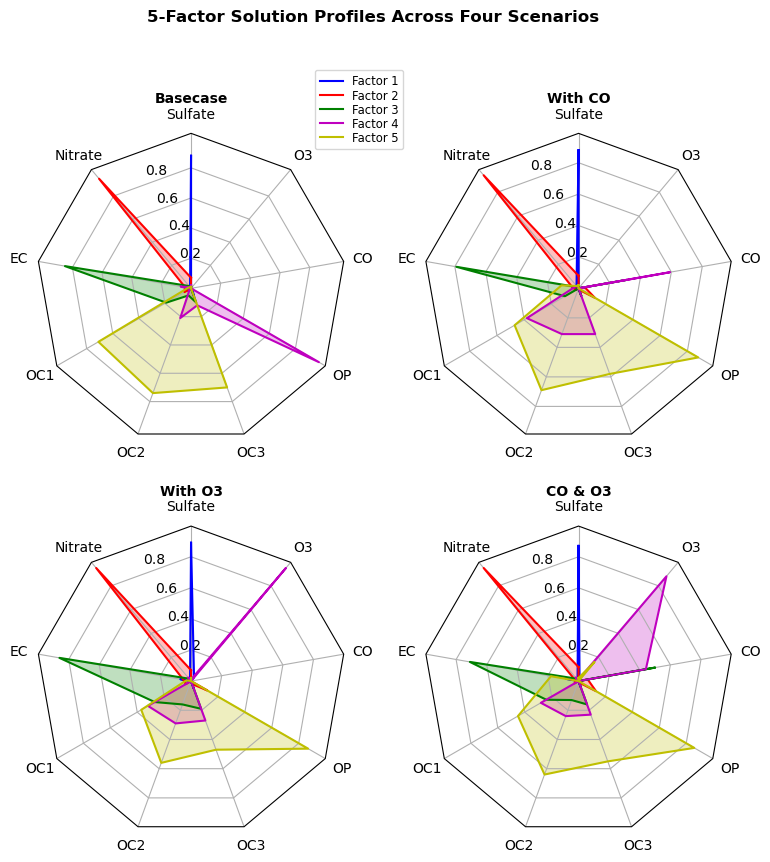

In [3]:
# example code
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [4]:
# example code 2 from Ryan Noonan on YT

# data
categories = ['Fuel Economy', 'Reliability', 'Comfort', 'Design', 'Repair Costs', 'Fuel Economy']

vehicle1 = [5,4,4,2,3]
# ***** to close the radar shape add the first list element to the end of the list or concatenate *****
vehicle1 = np.concatenate((vehicle1,[vehicle1[0]]))

vehicle2 = [3,4,5,5,4]
vehicle2 = np.concatenate((vehicle2,[vehicle2[0]]))

vehicle3 = [4,4,3,4,5]
vehicle3 = np.concatenate((vehicle3,[vehicle3[0]]))

In [5]:
l1 = [5,4,4,2,3]
l2 = l1 + [l1[0]]
l2

[5, 4, 4, 2, 3, 5]

In [6]:
# calculate evenly-spaced angle coordinates
# use radians for polar plot with 2*np.pi
label_placement = np.linspace(start=0, stop=2*np.pi, num=len(vehicle1))

In [7]:
print(2*np.pi, 'radians =', np.degrees(2*np.pi), 'degrees')

6.283185307179586 radians = 360.0 degrees


In [8]:
# radians
print('radians', label_placement)
# degrees
print('degrees', np.degrees(label_placement))

radians [0.         1.25663706 2.51327412 3.76991118 5.02654825 6.28318531]
degrees [  0.  72. 144. 216. 288. 360.]


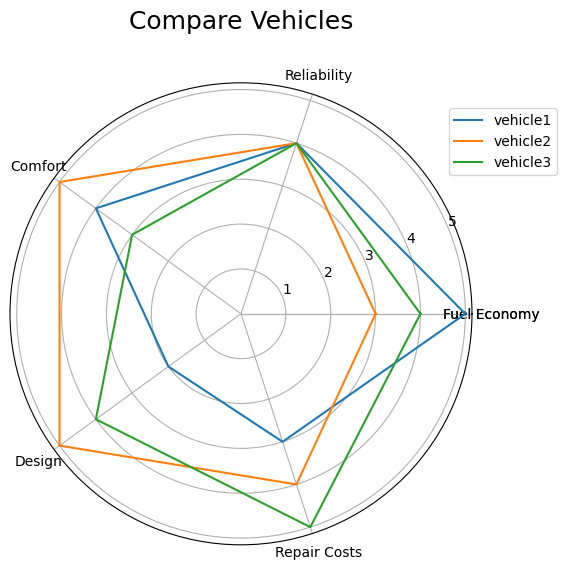

In [9]:
# create matplotlib figure and polar plot with labels, title, and legend
plt.figure(figsize=(6,6))
plt.subplot(polar=True)
plt.plot(label_placement, vehicle1)
# plt.fill(label_placement, vehicle1, 'blue', alpha=0.1)
plt.plot(label_placement, vehicle2)
plt.plot(label_placement, vehicle3)
# use thetagrids to place labels at the specified angles using degrees
lines, labels = plt.thetagrids(np.degrees(label_placement), labels=categories)
plt.title('Compare Vehicles', y=1.1, fontdict={'fontsize': 18})
plt.legend(labels=['vehicle1','vehicle2', 'vehicle3'],loc=(0.95, 0.8));

Text(0.5, 1.1, '$Ti_{38}V_{15}Nb_{23}Hf_{24}$')

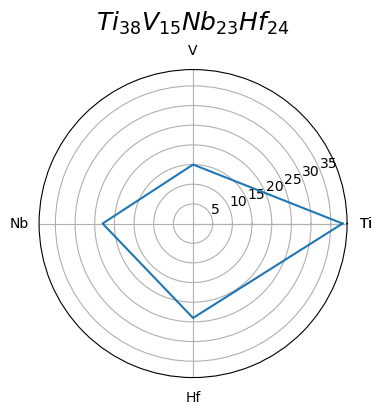

In [10]:
# Apply to HEA
categories = ['Ti', 'V', 'Nb', 'Hf']
categories = np.concatenate((categories,[categories[0]]))

alloy1 = [38.0, 15.0, 23.0, 24.0]
alloy1 = np.concatenate((alloy1,[alloy1[0]]))

label_placement = np.linspace(start=0, stop=2*np.pi, num=len(alloy1))

# create matplotlib figure and polar plot with labels, title, and legend
plt.figure(figsize=(4,4))
plt.subplot(polar=True)
plt.plot(label_placement, alloy1)
# plt.fill(label_placement, vehicle1, 'blue', alpha=0.1)
# plt.plot(label_placement, vehicle2)
# plt.plot(label_placement, vehicle3)
# use thetagrids to place labels at the specified angles using degrees
lines, labels = plt.thetagrids(np.degrees(label_placement), labels=categories)
plt.title('$Ti_{38}V_{15}Nb_{23}Hf_{24}$', y=1.1, fontdict={'fontsize': 18})
# plt.legend(labels=['Alloy 1'],loc=(0.95, 0.8));

In [11]:
def dictionary_to_alloy_latex_shorthand(alloy_dictionary):
    alloy_dictionary_keys = list(alloy_dictionary.keys())

    shorthand = "$"
    for key in alloy_dictionary_keys:
        if str(alloy_dictionary[key]).endswith("0") == True:
            shorthand += f"{key}_"
            shorthand += "{"
            shorthand += f"{alloy_dictionary[key]:.0f}"
            shorthand += "}"

        else:
            shorthand += f"{key}_"
            shorthand += "{"
            shorthand += f"{alloy_dictionary[key]:.3}"
            shorthand += "}"

    shorthand += "$"

    return shorthand

In [12]:
# make into a function that feed dictionary

def high_entropy_alloy_spider_compositions(alloy_dictionary):
    """Takes alloy composition as a dictionary"""
    alloy_components = list(alloy_dictionary.keys())
    

    alloy_component_values = list(alloy_dictionary.values())
    
    alloy_components = np.concatenate((alloy_components,[alloy_components[0]]))
    alloy_component_values = np.concatenate((alloy_component_values,[alloy_component_values[0]]))
    
    chart_title = dictionary_to_alloy_latex_shorthand(alloy_dictionary)

    label_placement = np.linspace(start=0, stop=2*np.pi, num=len(alloy_component_values))

    # create matplotlib figure and polar plot with labels, title, and legend
    plt.figure(figsize=(4,4))
    plt.subplot(polar=True)
    plt.plot(label_placement, alloy_component_values)

    lines, labels = plt.thetagrids(np.degrees(label_placement), labels=alloy_components)
    plt.title(chart_title, y=1.1, fontdict={'fontsize': 18})

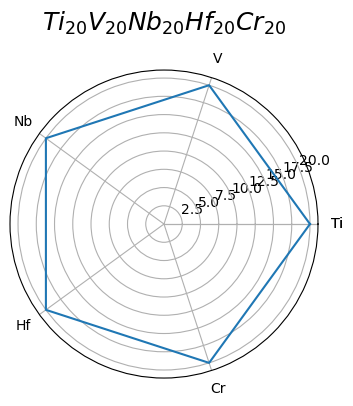

In [13]:
high_entropy_alloy_spider_compositions(batch_1_alloys[4])

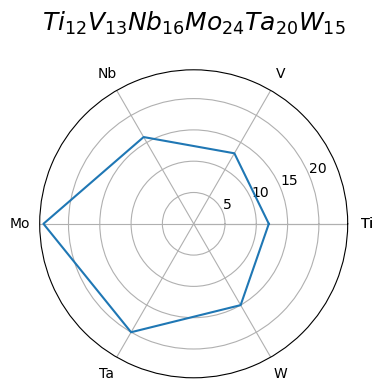

In [14]:
high_entropy_alloy_spider_compositions(nature_materials_alloys[2])

In [15]:
def high_entropy_alloy_spider_compositions_comparison(alloy_dictionary, experimental_alloy_dictionary, chart_title):
    """Takes alloy composition as a dictionary"""
    alloy_components = list(alloy_dictionary.keys())
    alloy_component_values = list(alloy_dictionary.values())

    experimental_alloy_components = list(experimental_alloy_dictionary.keys())
    experimental_alloy_component_values = list(experimental_alloy_dictionary.values())    
    
    alloy_components = np.concatenate((alloy_components,[alloy_components[0]]))
    alloy_component_values = np.concatenate((alloy_component_values,[alloy_component_values[0]]))
    
    experimental_alloy_components = np.concatenate((experimental_alloy_components,
                                                    [experimental_alloy_components[0]]))
    experimental_alloy_component_values = np.concatenate((experimental_alloy_component_values,
                                                          [experimental_alloy_component_values[0]]))
    
    alloy_labels = [dictionary_to_alloy_latex_shorthand(alloy_dictionary),
             dictionary_to_alloy_latex_shorthand(experimental_alloy_dictionary)]
    

    label_placement = np.linspace(start=0, stop=2*np.pi, num=len(alloy_component_values))

    # create matplotlib figure and polar plot with labels, title, and legend
    plt.figure(figsize=(4,4))
    plt.subplot(polar=True)
    plt.plot(label_placement, alloy_component_values)
    plt.plot(label_placement, experimental_alloy_component_values)
    lines, labels = plt.thetagrids(np.degrees(label_placement), labels=alloy_components)
    plt.title(chart_title, y=1.1, fontdict={'fontsize': 18})
    plt.legend(labels=alloy_labels,loc=(0.95, 0.8))
    
    return label_placement, alloy_component_values, experimental_alloy_component_values, chart_title, alloy_labels, alloy_components

(array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825,
        6.28318531]),
 array([20., 20., 20., 20., 20., 20.]),
 array([17.88679489, 17.77940997, 17.44114876, 17.9187583 , 28.97388809,
        17.88679489]),
 'B1-3',
 ['$Ti_{20}V_{20}Nb_{20}Hf_{20}Si_{20}$',
  '$Ti_{17.9}V_{17.8}Nb_{17.4}Hf_{17.9}Si_{29.0}$'],
 array(['Ti', 'V', 'Nb', 'Hf', 'Si', 'Ti'], dtype='<U2'))

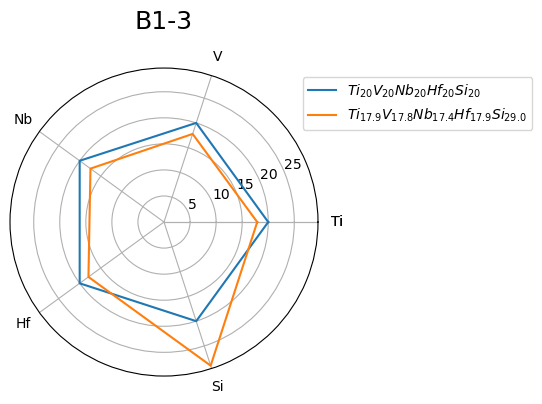

In [16]:
sample_shorthand = ['B1-1', 'B1-2', 'B1-3', 'B1-4', 'B1-5']

sample = 2

high_entropy_alloy_spider_compositions_comparison(batch_1_alloys[sample], 
                                                  batch_1_experimental_alloys[sample], 
                                                  sample_shorthand[sample])

AttributeError: 'Axes' object has no attribute 'thetagrids'

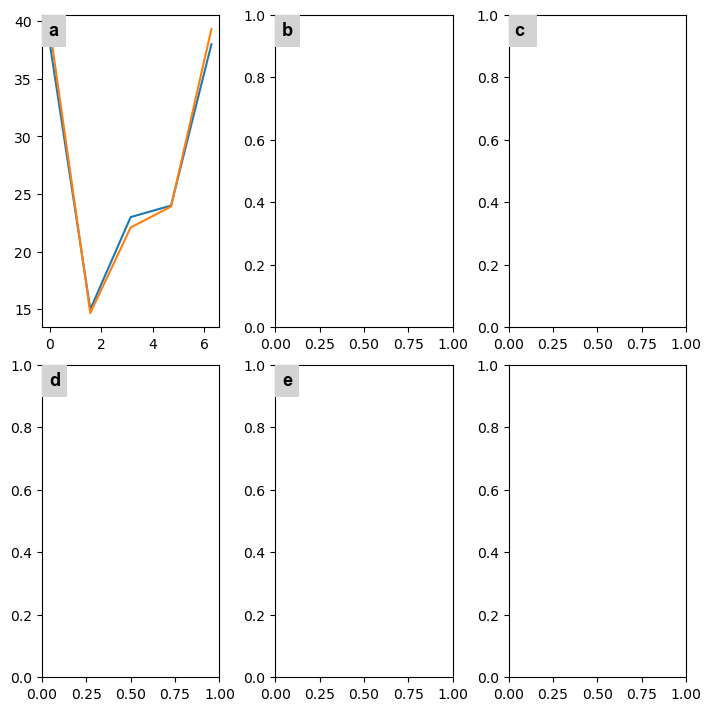

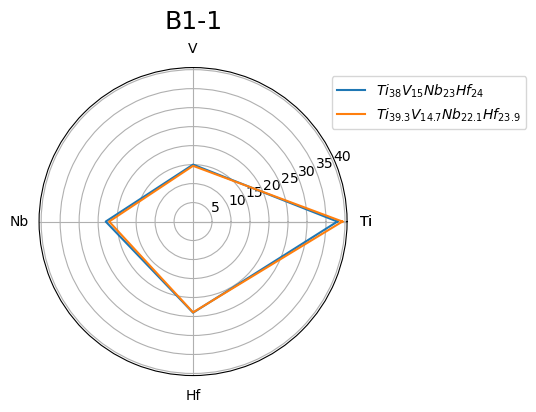

In [17]:
#nature style

fig, axs = plt.subplot_mosaic([['a', 'b', 'c '],
                               ['d', 'e', '']], figsize=(7, 7),
                              layout='constrained')

### style parameters according to Nature style guidelines
subplot_labels = ['a', 'b', 'c ', 'd', 'e', 'f ', 'g', 'h', 'i']

fontSize = 8
fontFamily = 'arial'
markerSize = 4
#fontFamily = 'times new roman'

# fontProp = matplotlib.font_manager.FontProperties(family = fontFamily, style=None, variant=None, weight=None, stretch=None, size= fontSize, fname=None, 
#                math_fontfamily=None)

### adds label to plots

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize=fontSize + 5, fontweight = "bold", fontfamily = fontFamily, verticalalignment='top',bbox=dict(facecolor='#D3D3D3', edgecolor='none', pad=5.0))

for i in range(len(batch_1_alloys)):
    label_placement, alloy_component_values, experimental_alloy_component_values, chart_title, alloy_labels, alloy_components = high_entropy_alloy_spider_compositions_comparison(batch_1_alloys[i], 
                                                  batch_1_experimental_alloys[i], 
                                                  sample_shorthand[i])
    
    axs[subplot_labels[i]].plot(polar=True)
    axs[subplot_labels[i]].plot(label_placement, alloy_component_values)
    axs[subplot_labels[i]].plot(label_placement, experimental_alloy_component_values)
    lines, labels = axs[subplot_labels[i]].thetagrids(np.degrees(label_placement), labels=alloy_components)
#     axs[subplot_labels[i]].text(chart_title, y=1.1, fontdict={'fontsize': 18})
    axs[subplot_labels[i]].legend(labels=alloy_labels,loc=(0.95, 0.8))
    
# y_pos = np.arange(len(batch_1_alloys_measured))

# # for i in range(len(samples)):
# axs[''].barh(y_pos, [1,1,1,1,1], color = sample_color, align='center')
# # ax.set_yticks(y_pos, labels=samples)
# axs[''].invert_yaxis()  # labels read top-to-bottom

# axs[''].spines["right"].set_visible(False)
# axs[''].spines["top"].set_visible(False)
# axs[''].spines["bottom"].set_visible(False)
# axs[''].spines["left"].set_visible(False)

# for i in range(len(y_pos)):
#         plt.text(1.2, y_pos[i], batch_1_alloys_measured[i], color = 'k')
# axs[''].set_xticks([0, 10])
# axs[''].set_xticks([])
# axs[''].set_yticks([])

fig.savefig('batch 1_HEA spider.tiff' ,dpi=800)
fig.savefig('batch 1_HEA spider.jpg' ,dpi=800)